In [1]:
from matplotlib import pyplot as plt
from astropy.io import fits
import numpy as np
from scipy import ndimage
import re
import glob

from astropy.utils.data import get_file_contents
import astropy.units as u

%matplotlib inline
from IPython.utils import io

/home/panoptes/anaconda3/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# Load the PANOPTES module dir
import sys
sys.path.append('../..')

# For development
%load_ext autoreload
%autoreload 2

from panoptes.utils.images import *

INFO:PanoptesLogger:

INFO:PanoptesLogger:********************************************************************************
INFO:PanoptesLogger:

DEBUG:PanoptesLogger:Adding warning logging to: PanError
DEBUG:PanoptesLogger:Adding warning logging to: SerialData
DEBUG:PanoptesLogger:Adding warning logging to: PanStateMachine
DEBUG:PanoptesLogger:Adding warning logging to: AbstractCamera
DEBUG:PanoptesLogger:Adding warning logging to: Observation
DEBUG:PanoptesLogger:Adding warning logging to: Target
DEBUG:PanoptesLogger:Adding warning logging to: Scheduler
DEBUG:PanoptesLogger:Adding warning logging to: Observatory
DEBUG:PanoptesLogger:Adding warning logging to: Panoptes
DEBUG:PanoptesLogger:Adding warning logging to: Messaging
DEBUG:PanoptesLogger:Adding warning logging to: EnvironmentalMonitor
DEBUG:PanoptesLogger:Adding warning logging to: Webcams
DEBUG:PanoptesLogger:Adding warning logging to: PanSensors


In [3]:
d = '/var/panoptes/images/20150920/raw'
!cd $d

In [27]:
cr2_files = glob.glob('{}/01_*.cr2'.format(d))
cr2_files.sort()
cr2_files

['/var/panoptes/images/20150920/raw/01_11.cr2',
 '/var/panoptes/images/20150920/raw/01_12.cr2',
 '/var/panoptes/images/20150920/raw/01_120.cr2',
 '/var/panoptes/images/20150920/raw/01_121.cr2',
 '/var/panoptes/images/20150920/raw/01_122.cr2',
 '/var/panoptes/images/20150920/raw/01_123.cr2',
 '/var/panoptes/images/20150920/raw/01_124.cr2',
 '/var/panoptes/images/20150920/raw/01_125.cr2',
 '/var/panoptes/images/20150920/raw/01_126.cr2',
 '/var/panoptes/images/20150920/raw/01_127.cr2',
 '/var/panoptes/images/20150920/raw/01_128.cr2',
 '/var/panoptes/images/20150920/raw/01_129.cr2',
 '/var/panoptes/images/20150920/raw/01_140.cr2',
 '/var/panoptes/images/20150920/raw/01_141.cr2',
 '/var/panoptes/images/20150920/raw/01_142.cr2',
 '/var/panoptes/images/20150920/raw/01_143.cr2',
 '/var/panoptes/images/20150920/raw/01_144.cr2',
 '/var/panoptes/images/20150920/raw/01_145.cr2',
 '/var/panoptes/images/20150920/raw/01_146.cr2',
 '/var/panoptes/images/20150920/raw/01_150.cr2',
 '/var/panoptes/images

In [34]:
c = cr2_files[0]

In [35]:
!dcraw -i -v $c


Filename: /var/panoptes/images/20150920/raw/01_11.cr2
Timestamp: Sun Sep 20 04:45:36 2015
Camera: Canon EOS REBEL SL1
ISO speed: 100
Shutter: 29.9 sec
Aperture: f/inf
Focal length: 0.0 mm
Embedded ICC profile: no
Number of raw images: 1
Thumb size:  5184 x 3456
Full size:   5280 x 3528
Image size:  5208 x 3476
Output size: 5208 x 3476
Raw colors: 3
Filter pattern: RGGBRGGBRGGBRGGB
Daylight multipliers: 2.266767 0.938615 1.281072
Camera multipliers: 2068.000000 1024.000000 1589.000000 1024.000000


In [21]:
pixel_scale = ((206.265) * (18.5 * u.micron) / (85 * u.mm)).cgs * u.arcsecond

In [22]:
def compare(f0, f1, pixel_scale=0.):
    print(f0, f1)
    raw_data_00 = read_pgm(cr2_to_pgm(f0))
    raw_data_01 = read_pgm(cr2_to_pgm(f1))

    
    x0, y0 = measure_offset(raw_data_00,raw_data_01, box_width=200)
    
    #with io.capture_output() as captured:    
    #    !/var/panoptes/bin/measure_offset $f0 $f1 
        
    #x1 = float(get_file_contents('xcent.txt'))
    #y1 = float(get_file_contents('ycent.txt'))

    #return ( x0, y0, x1, y1 )
    return (x0, y0)

In [23]:
comparison = {}

for i in np.arange(len(cr2_files)):
    if i < len(cr2_files) - 1:
        print(i)
        comparison[i] = compare(cr2_files[i], cr2_files[i+1], pixel_scale)
        
comparison

0
/var/panoptes/images/20150920/raw/01_150.cr2 /var/panoptes/images/20150920/raw/01_151.cr2
1
/var/panoptes/images/20150920/raw/01_151.cr2 /var/panoptes/images/20150920/raw/01_152.cr2
2
/var/panoptes/images/20150920/raw/01_152.cr2 /var/panoptes/images/20150920/raw/01_153.cr2
3
/var/panoptes/images/20150920/raw/01_153.cr2 /var/panoptes/images/20150920/raw/01_154.cr2
4
/var/panoptes/images/20150920/raw/01_154.cr2 /var/panoptes/images/20150920/raw/01_155.cr2
5
/var/panoptes/images/20150920/raw/01_155.cr2 /var/panoptes/images/20150920/raw/01_156.cr2
6
/var/panoptes/images/20150920/raw/01_156.cr2 /var/panoptes/images/20150920/raw/01_157.cr2
7
/var/panoptes/images/20150920/raw/01_157.cr2 /var/panoptes/images/20150920/raw/01_158.cr2
8
/var/panoptes/images/20150920/raw/01_158.cr2 /var/panoptes/images/20150920/raw/01_159.cr2
9
/var/panoptes/images/20150920/raw/01_159.cr2 /var/panoptes/images/20150920/raw/01_160.cr2
10
/var/panoptes/images/20150920/raw/01_160.cr2 /var/panoptes/images/20150920/ra

{0: (0.5, -0.5),
 1: (0.5, -0.5),
 2: (0.27272727272727271, -0.27272727272727271),
 3: (0.090909090909090912, -0.27272727272727271),
 4: (0.61538461538461542, -0.46153846153846156),
 5: (0.2857142857142857, -0.21428571428571427),
 6: (0.0, -0.40000000000000002),
 7: (-0.18181818181818182, -0.45454545454545453),
 8: (-0.21428571428571427, -0.21428571428571427),
 9: (0.45454545454545453, -0.54545454545454541),
 10: (0.0, -0.18181818181818182),
 11: (0.5, -0.5),
 12: (1.0769230769230769, -0.076923076923076927),
 13: (-0.1762114537444934, -0.26431718061674009),
 14: (-1.2185430463576159, -0.25165562913907286),
 15: (-0.35021097046413502, -0.1729957805907173),
 16: (0.84974093264248707, -0.32642487046632124),
 17: (-0.76923076923076927, -0.028846153846153848),
 18: (-1.3972602739726028, -0.22602739726027396),
 19: (0.88059701492537312, -0.11442786069651742),
 20: (0.044897959183673466, -0.12653061224489795),
 21: (-1.180232558139535, -0.19767441860465115),
 22: (-0.62222222222222223, -0.122

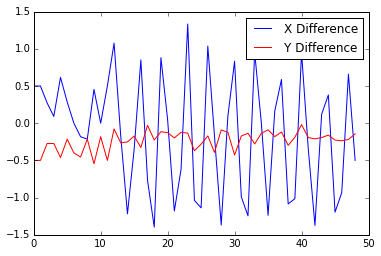

In [26]:
x0 = [v[0] for v in comparison.values()]
y0 = [v[1] for v in comparison.values()]
#x1 = [v[2] for v in comparison.values()]
#y1 = [v[3] for v in comparison.values()]

r = np.arange(len(comparison))

plt.plot(r, x0, color='b', label="X Difference")
plt.plot(r, y0, color='r', label="Y Difference")
#plt.scatter(r, x1, color='g', linewidths=2.)
#plt.scatter(r, y1, color='k', linewidths=2.)
plt.legend()

In [ ]:
x1 * pixel_scale.to(u.ms)